In [1]:
# Imports 
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Reading Data

Create data structure for each peice of audio.
- Audio file
- Annotation file
- annotated beats
- tracked beats
- evaluation?

### Single file loading

In [2]:
# data/BallroomData/Quickstep/Albums-Ballroom_Classics4-20.wav - 204 BPM 
# data/BallroomData/Quickstep/Albums-Chrisanne2-11.wav - 204 BPM 
# data/BallroomData/Tango/Media-105508.wav - 128 BPM
# data/BallroomData/ChaChaCha/Albums-Cafe_Paradiso-08.wav - Easy 124  - BPM 
# data/BallroomData/Rumba-American/Albums-GloriaEstefan_MiTierra-04.wav - 122 BPM
# data/BallroomData/Waltz/Albums-Ballroom_Classics4-01.wav - Very hard - 87 BPM 
# data/BallroomData/Jive/Albums-Cafe_Paradiso-16.wav # Easy - 172 BPM

# get file
beats_path = 'data/BallroomData/Waltz/Albums-Ballroom_Classics4-01.wav'

# resample rate - based on method of ellis 2007
resample_rate = 8000

# load audio
y, sr = librosa.load(beats_path, sr=resample_rate)



# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative value set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide - I havent done this
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

In [3]:
from scipy.signal import butter, filtfilt, lfilter

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    """Apply a high-pass filter to the signal."""
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004, show=False):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa remove DC like this - How do they do this in lab solution?
    onset_strength = lfilter([1.0, -1.0], [1.0, -0.99], onset_strength, axis=-1)
    
    # normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    if(show): plot_onset_envelope_strength(y, onset_strength_norm, hop_sec)
        
    return onset_strength_norm

def plot_onset_envelope_strength(y, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    
    # normalise range 0 - 1
    onset_strength = onset_strength / np.max(onset_strength)
    
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.ylim([-0.1, 1.1])
    plt.show()

hop_sec=0.004
ose = onset_strength_envelope(y, sr, hop_sec=hop_sec)




# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

In [4]:

def plot_auto_c(auto_c, tps, faster_tempo, slower_tempo, selected_tempo, sr, hop_length):
    # calculate bpm for plot
    faster_tempo_bpm = round(60 * sr / (faster_tempo * hop_length), 2)
    slower_tempo_bpm = round(60 * sr / (slower_tempo * hop_length), 2)
    selected_tempo_bpm = round(60 * sr / (selected_tempo * hop_length), 2)
    
    auto_c = auto_c / np.max(auto_c)
    tps = tps / np.max(tps)
    
    times = np.arange(len(auto_c)) * (hop_length / sr)

    plt.plot(times, auto_c)
    plt.title('Auto-Correlation')
    plt.xlabel('Lag (seconds)')
    plt.show()

    plt.plot(times, tps)
    plt.vlines(faster_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='g', linestyle='--', label='faster tempo: {} BPM'.format(faster_tempo_bpm))
    plt.vlines(slower_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='r', linestyle='--', label='slower tempo: {} BPM'.format(slower_tempo_bpm))
    plt.legend()
    plt.title('Perception Weighted Auto-Correlation Tempo BPM: {}'.format(selected_tempo_bpm))
    plt.xlabel('Lag (seconds)')
    plt.show()
    
# Apply perceptual weighting based on tempo tapping data
def perceptual_weighting(t, t0=0.5, sigma_t=0.9): # t0 (bpm) and sigma_t (octaves) values from ellis 2007  
    # avoid div by zero error 
    epsilon = 1e-10
    t = np.maximum(t, epsilon)
    
    log_2_t_over_t0 = np.log2(t / t0)
    
    W_t = np.exp(-0.5 * (log_2_t_over_t0 / sigma_t) ** 2)
    
    return W_t

def tempo_multiples(tps):
    # only search 1/3 of the tps this should be plenty with 5 second tps
    tps_range = round(len(tps) / 3)
    
    tps_2 = np.zeros(tps_range)
    tps_3 = np.zeros(tps_range)

    for t in range(tps_range):
        # equation (7) and (8) - ellis 2007
        tps_2[t] = tps[t] + (0.5 * tps[2 * t]) + (0.25 * tps[(2 * t) - 1]) + (0.25 * tps[(2 * t) + 1])
        tps_3[t] = tps[t] + (0.33 * tps[3 * t]) + (0.33 * tps[(3 * t) - 1]) +(0.33 * tps[(3 * t) + 1])            
        
    duple = np.max(tps_2)
    triple = np.max(tps_3)
     
    # Whichever sequence contains the larger value determines whether the tempo is considered 
    # duple or triple, respectively, and the location of the largest value is treated as the 
    # faster target tempo, with one-half or one-third of that tempo, respectively, as the adjacent 
    # metrical level.   
    if duple > triple:
        faster_tempo_frame = np.argmax(tps_2)
        slower_tempo_frame = np.argmax(tps_2) * 2
        return faster_tempo_frame, slower_tempo_frame
    else: 
        faster_tempo_frame = np.argmax(tps_3)
        slower_tempo_frame = np.argmax(tps_3) * 3
        return faster_tempo_frame, slower_tempo_frame
  
def estimate_tempo(odf, sr, hop_sec=0.004, max_lag_s=5, weight_threshold_ratio=0.15, show=False):
    hop_length = int(hop_sec * sr)

    # only correlate reasonable tempo range 
    max_size = max_lag_s * sr / hop_length

    # auto correlate onset strength
    auto_c = librosa.autocorrelate(odf, max_size=max_size)

    # weighting function needs lag in seconds
    lags_seconds = np.arange(len(auto_c)) * (hop_length / sr)

    # apply perceptual weightinig get tempo period strengths
    tps = perceptual_weighting(lags_seconds) * auto_c
    
    # # calculate secondary bpm
    # # two further functions are calculated by resampling T P S to one-half and one-third, 
    # # respectively, of its original length, adding this to the original T P S, 
    # # then choosing the largest peak across both these sequences - ellis 2007
    faster_tempo_frame, slower_tempo_frame = tempo_multiples(tps)
    
    # Relative weights of the two levels are again taken from the relative peak heights 
    # at the two period estimates in the original T P S. This approach finds the tempo that maximizes
    # the sum of the T P S values at both metrical levels
    faster_tempo_peak = tps[faster_tempo_frame]
    slower_tempo_peak = tps[slower_tempo_frame]
    
    # find the nomalised strength of each tempo 
    faster_tempo_weight = faster_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
    slower_tempo_weight = slower_tempo_peak / (faster_tempo_peak + slower_tempo_peak)
               
    # start testing without - risk of over fitting to data set
    # weight difference decision rule - not explicitly mentioned in the paper - this is my interpretation 
    
    # weight difference threshold
    if (slower_tempo_weight > faster_tempo_weight): selected_tempo = slower_tempo_frame
    # test with decision rule - add in comparison to original tps peak 
    #else if abs(faster_tempo_weight - slower_tempo_weight) > weight_threshold_ratio: selected_tempo = slower_tempo_frame
    else: selected_tempo = faster_tempo_frame
        
    # plot results
    if(show): 
        print("faster_tempo_level: {}, slower_tempo_level {}".format(faster_tempo_peak, slower_tempo_peak))
        print("faster_tempo weigth: {}, slower_tempo weight {}".format(faster_tempo_weight, slower_tempo_weight))
        print('weight ratio: {}'.format(abs(faster_tempo_weight - slower_tempo_weight)))
        plot_auto_c(auto_c, tps, faster_tempo_frame, slower_tempo_frame, selected_tempo, sr, hop_length)

    return selected_tempo

tempo_estimate = estimate_tempo(ose, sr, hop_sec)

# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

In [12]:
def plot_dynamic_programming(c_score, backlink, ose, beats):
    # Plot the cumulative score and onset strength envelope
    plt.figure(figsize=(14, 6))
    plt.plot(ose, label='Onset Strength Envelope', color='blue', alpha=0.5)
    plt.plot(c_score, label='Cumulative Score', color='orange', alpha=0.8)

    # Add arrows for backlinks
    for i in range(1, len(c_score)):
        if backlink[i] != -1:
            plt.annotate('', xy=(i, c_score[i]), xytext=(backlink[i], c_score[backlink[i]]),
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.5))

    # Highlight the beats
    plt.scatter(beats, c_score[beats], color='red', zorder=5, label='Beats')

    plt.title('Dynamic Programming Beat Tracking Visualization')
    plt.xlabel('Time (frames)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# ported from ellis 2007 matlab code
def beat_track(ose, tempo_estimate, sr, alpha=680, hop_sec=0.004, show=False):
    # initialize backlink and cumulative score arrays
    backlink = -np.ones(len(ose), dtype=int)
    c_score = ose.copy()
    
    # define search range for previous beat based on the period
    prev_range = np.arange(-2*tempo_estimate, -round(tempo_estimate/2), dtype=int)
    
    # calculate transition cost using a log-gaussian window over the search range
    cost = -alpha * np.abs(np.log(prev_range / -tempo_estimate) ** 2)

    # set up the dynamic programming loop bounds
    loop_start = max(-prev_range[0], 0)
    loop_end = len(ose)
    
    # use the loop to fill in backlink and cumlative score
    for i in range(loop_start, loop_end):
        timerange = i + prev_range
        # ensure timerange indices are within bounds
        valid_timerange = timerange[(timerange >= 0) & (timerange < len(ose))]
        if len(valid_timerange) == 0:
            continue  # skip if no valid timerange
        
        # calculate score candidates and find the best predecessor beat
        score_candiadates = cost[:len(valid_timerange)] + c_score[valid_timerange]
        max_score_index = np.argmax(score_candiadates)
        max_score = score_candiadates[max_score_index]
        
        # update cumulative score and backlink
        c_score[i] = max_score + ose[i]
        backlink[i] = valid_timerange[max_score_index]
    
    # start backtrace from the highest cumulative score
    beats = [np.argmax(c_score)]
    
    # backtrace to find all predecessors
    while backlink[beats[0]] > 0:
        beats.insert(0, backlink[beats[0]])
    
    hop_length = int(hop_sec * sr)
    times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    
    if(show): plot_dynamic_programming(c_score, backlink, ose, beats) # this can take more than 1 minute to render
    
    return times

beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec)

# librosa to compare
# tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
# beat_times = librosa.frames_to_time(beats, sr=sr) # to get times from frames

# plt.figure(figsize=(10, 4))
# plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
# plt.vlines(beat_times, ymin=min(y), ymax=max(y), color='r', linestyle='--', label='Onsets')  # plot beats
# plt.title('Beat tracking - BPM: {}'.format(tempo))
# plt.xlim(x_lim)


# Evaluation

In [6]:
from mir_eval import beat as beats_eval

def evaluation(beats_ref, beats_est, trim=False):
    if trim: 
        beats_ref = beats_eval.trim_beats(beats_ref)
        beats_est = beats_eval.trim_beats(beats_est)
    
    f_measure = beats_eval.f_measure(beats_ref, beats_est)
    cemgil = beats_eval.cemgil(beats_ref, beats_est)
    goto = beats_eval.goto(beats_ref, beats_est)
    # p_score = beats_eval.p_score(beats_ref, beats_est) broken: numpy depricated int error in mir_eval lib
    continuity = beats_eval.continuity(beats_ref, beats_est)
    information_gain = beats_eval.information_gain(beats_ref, beats_est)
    
    return {
        "f_measure": f_measure, 
        "cemgil": cemgil,
        "goto": goto,
        #"p_score": p_score, broken - see above comment
        "continuity": continuity, 
        "information_gain": information_gain 
    }

# scores = evaluation(beats_reference, beats_estimates) # test with and without trim

# print(scores['f_measure'])

# Testing on full dataset

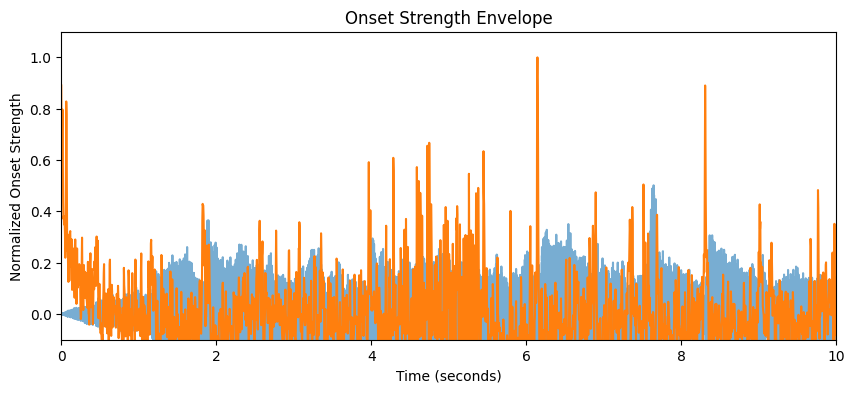

faster_tempo_level: 1405.225309083889, slower_tempo_level 1524.0028949217558
faster_tempo weigth: 0.4797254468471522, slower_tempo weight 0.5202745531528479
weight ratio: 0.04054910630569569


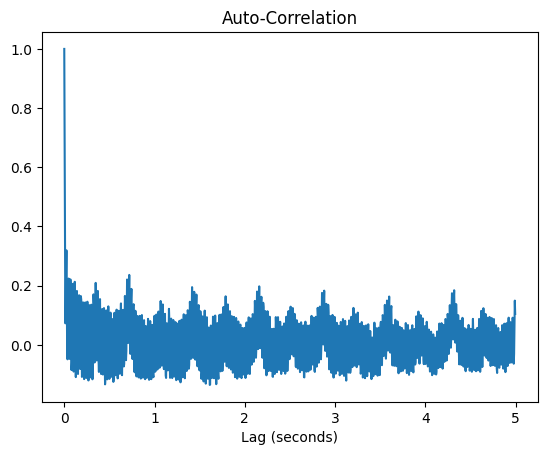

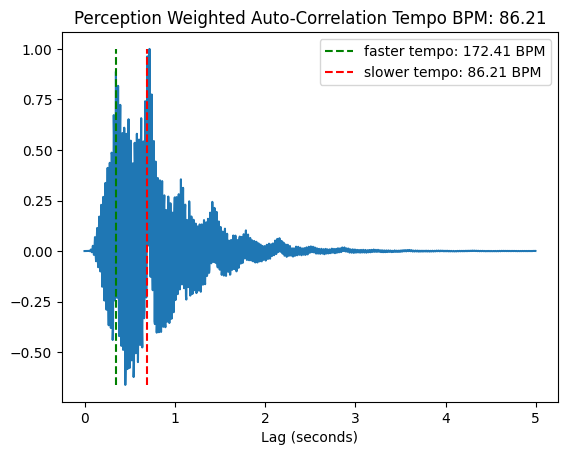

data/BallroomData/Waltz/Media-105901.wav
[ 1.16   1.852  2.56   3.268  3.988  4.724  5.448  6.144  6.86   7.572
  8.308  9.02   9.764 10.472 11.184 11.904 12.62  13.34  14.052 14.772
 15.492 16.22  16.936 17.652 18.356 19.068 19.804 20.52  21.236 21.952
 22.66  23.352 24.068 24.808 25.536 26.244 26.948 27.644 28.344 29.02
 29.724]
0.7901234567901235


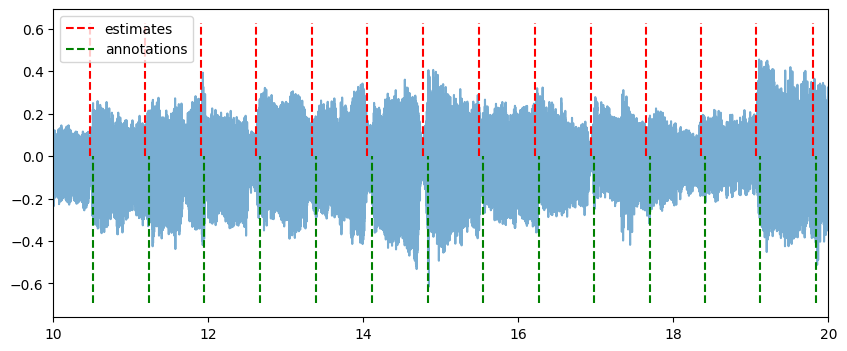

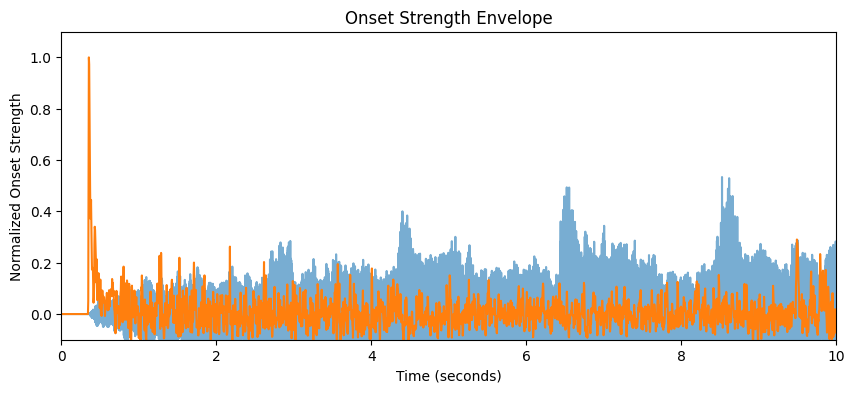

faster_tempo_level: 805.8302990101314, slower_tempo_level 597.9801762218449
faster_tempo weigth: 0.5740306923389853, slower_tempo weight 0.4259693076610146
weight ratio: 0.1480613846779707


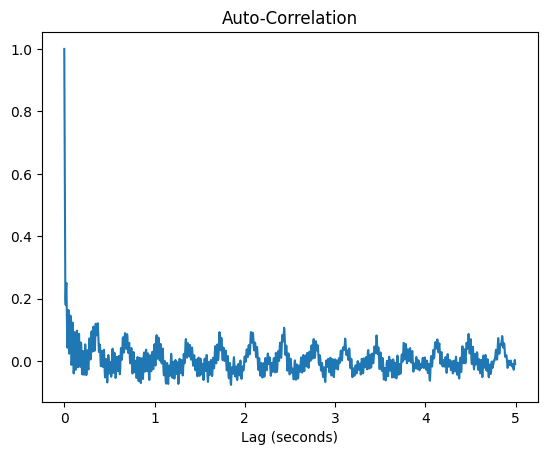

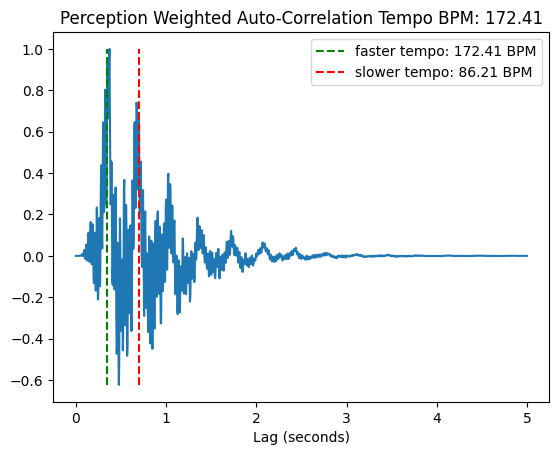

data/BallroomData/Waltz/Albums-Step_By_Step-04.wav
[ 0.356  0.712  1.08   1.452  1.824  2.176  2.524  2.872  3.216  3.568
  3.912  4.26   4.62   4.972  5.324  5.676  6.028  6.384  6.744  7.096
  7.444  7.792  8.136  8.484  8.816  9.16   9.504  9.856 10.2   10.544
 10.884 11.232 11.58  11.92  12.272 12.616 12.968 13.308 13.644 13.992
 14.344 14.696 15.04  15.384 15.724 16.072 16.416 16.76  17.1   17.424
 17.756 18.096 18.444 18.808 19.156 19.496 19.84  20.184 20.54  20.884
 21.236 21.584 21.94  22.288 22.636 22.972 23.312 23.656 24.004 24.36
 24.708 25.048 25.396 25.74  26.084 26.42  26.764 27.104 27.448 27.784
 28.12  28.464 28.812 29.16  29.504 29.844]
0.6307692307692307


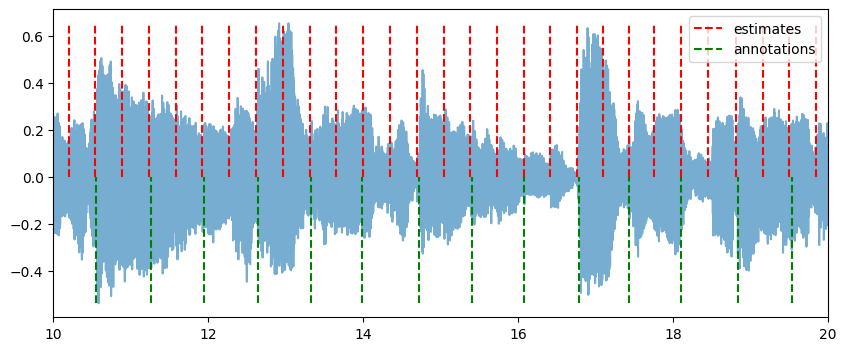

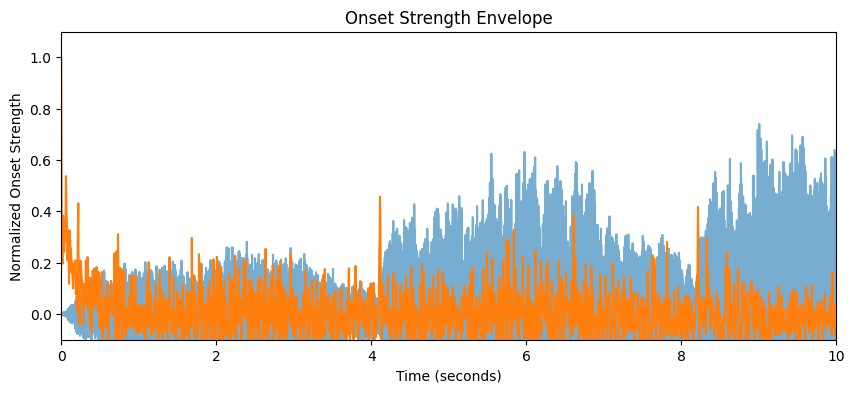

faster_tempo_level: 1107.1172093350995, slower_tempo_level 816.5717667087475
faster_tempo weigth: 0.5755177802245016, slower_tempo weight 0.42448221977549827
weight ratio: 0.15103556044900335


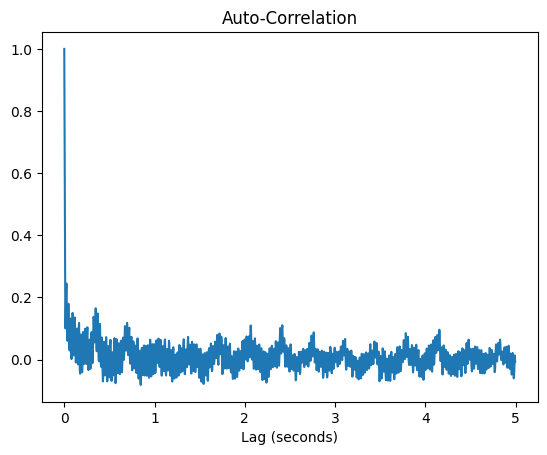

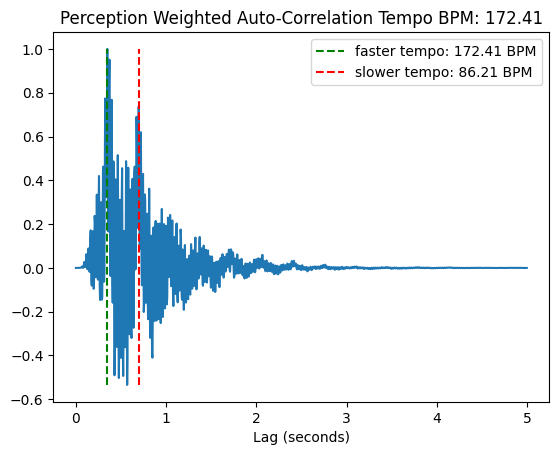

data/BallroomData/Waltz/Media-104202.wav
[ 0.64   0.988  1.332  1.684  2.032  2.38   2.728  3.064  3.404  3.756
  4.112  4.448  4.796  5.148  5.492  5.84   6.188  6.512  6.84   7.184
  7.536  7.876  8.216  8.572  8.916  9.256  9.608  9.952 10.292 10.636
 10.988 11.328 11.672 12.02  12.368 12.7   13.04  13.388 13.736 14.08
 14.424 14.768 15.108 15.444 15.788 16.144 16.488 16.836 17.18  17.524
 17.876 18.228 18.56  18.908 19.26  19.604 19.94  20.28  20.62  20.952
 21.304 21.664 22.004 22.356 22.7   23.044 23.392 23.74  24.08  24.416
 24.76  25.112 25.46  25.804 26.148 26.496 26.84  27.18  27.528 27.872
 28.212 28.556 28.896 29.236 29.58  29.936 30.284]
0.6


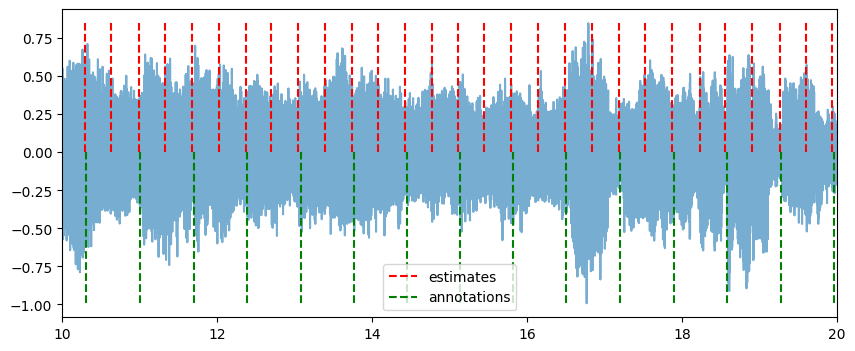

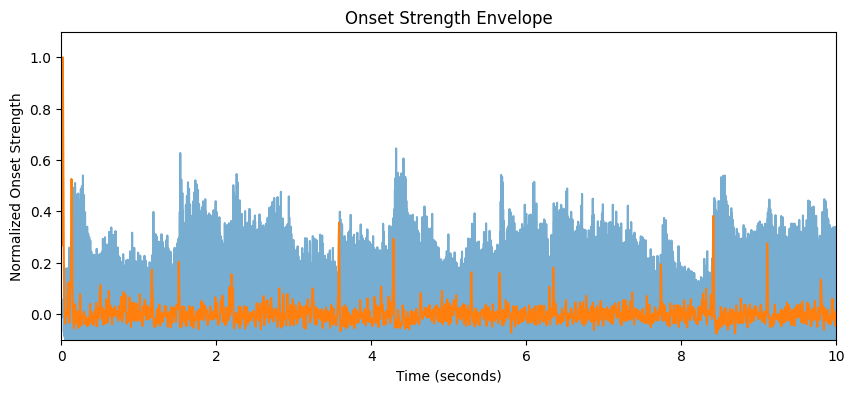

faster_tempo_level: 194.16223880192604, slower_tempo_level 880.6479151947124
faster_tempo weigth: 0.18064793868939696, slower_tempo weight 0.8193520613106031
weight ratio: 0.6387041226212061


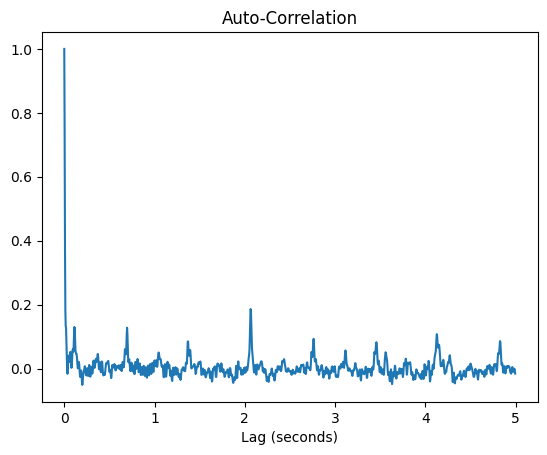

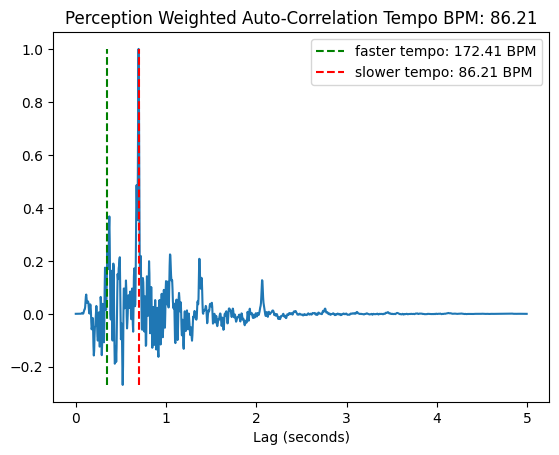

data/BallroomData/Waltz/Media-104203.wav
[ 0.804  1.516  2.2    2.916  3.584  4.288  4.98   5.656  6.348  7.044
  7.736  8.412  9.108  9.8   10.476 11.176 11.872 12.548 13.224 13.944
 14.64  15.328 16.012 16.704 17.38  18.06  18.768 19.444 20.144 20.824
 21.516 22.212 22.912 23.58  24.272 24.972 25.648 26.32  26.996 27.692
 28.388 29.096 29.8  ]
0.9885057471264368


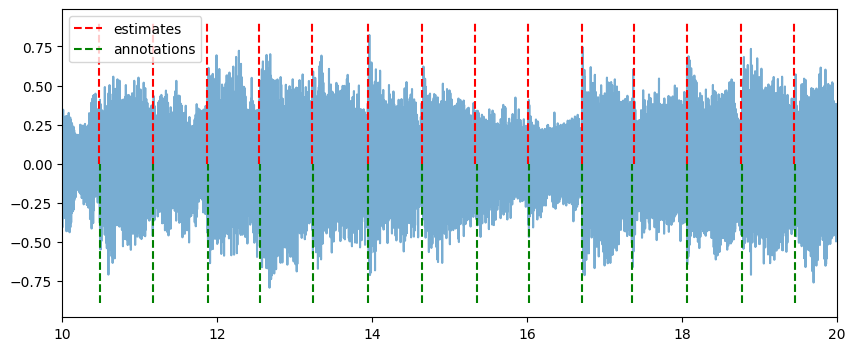

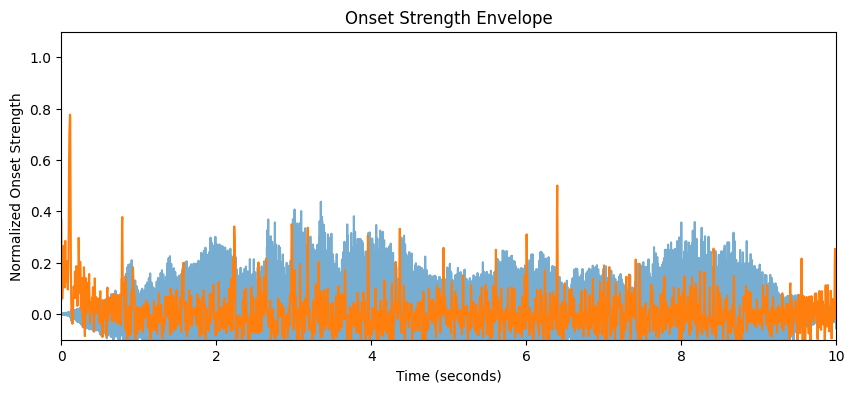

faster_tempo_level: 284.91778500894384, slower_tempo_level 417.54321040148176
faster_tempo weigth: 0.4055994380762386, slower_tempo weight 0.5944005619237615
weight ratio: 0.18880112384752284


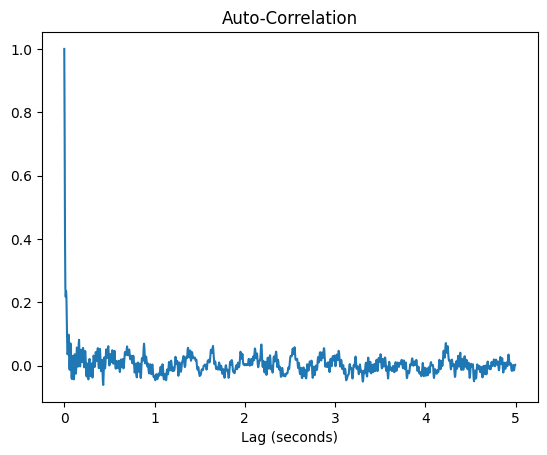

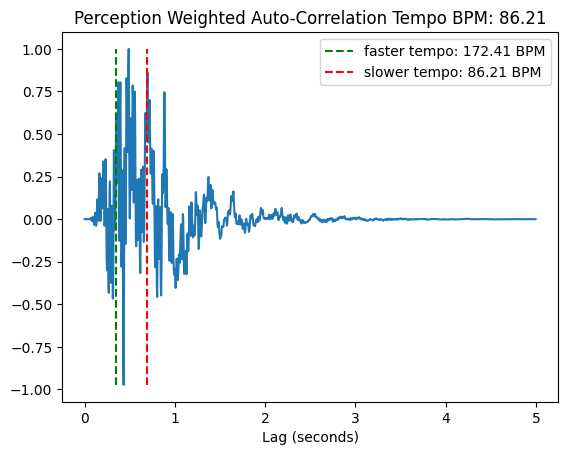

data/BallroomData/Waltz/Media-105902.wav
[ 0.836  1.536  2.236  2.972  3.66   4.368  5.084  5.788  6.496  7.208
  7.904  8.592  9.304  9.984 10.696 11.392 12.076 12.764 13.44  14.172
 14.896 15.584 16.316 16.984 17.668 18.356 19.052 19.78  20.496 21.212
 21.9   22.612 23.328 24.044 24.752 25.456 26.136 26.856 27.588 28.284
 29.008 29.708]
0.9176470588235294


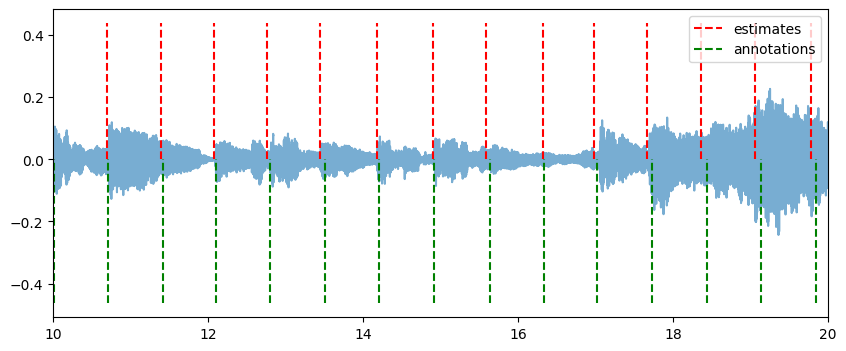

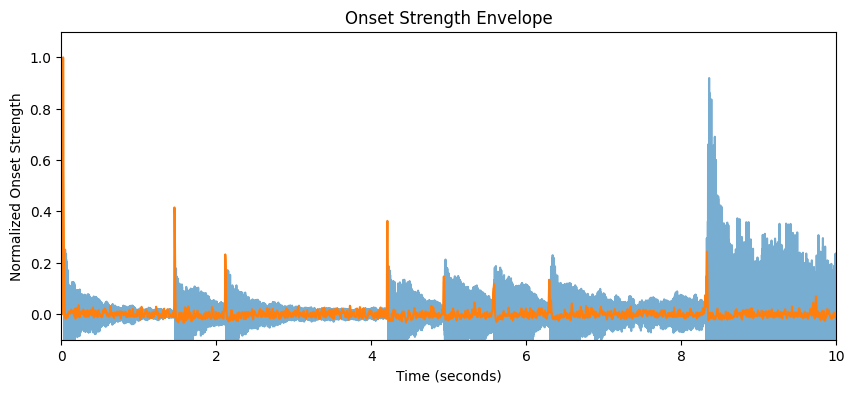

faster_tempo_level: 279.2560421862523, slower_tempo_level 296.74612863426603
faster_tempo weigth: 0.48481769051052437, slower_tempo weight 0.5151823094894755
weight ratio: 0.030364618978951152


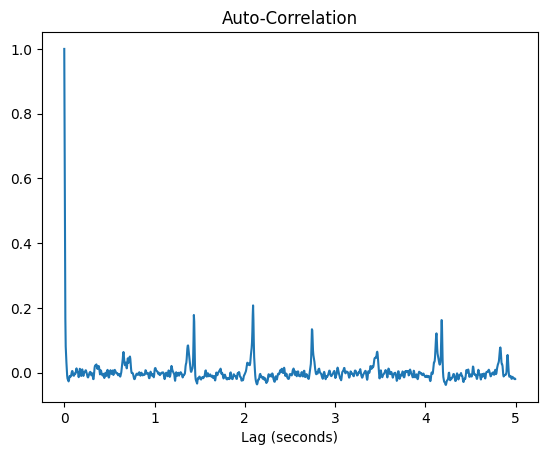

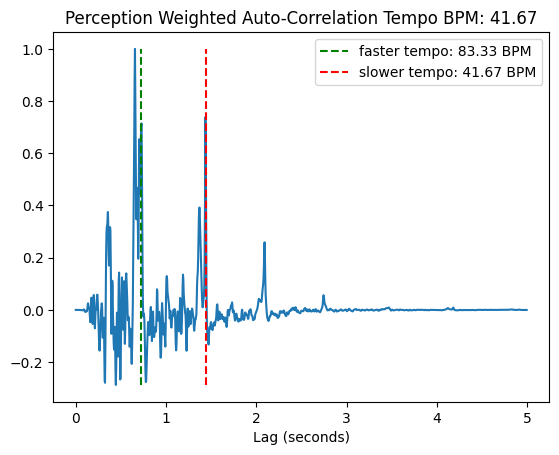

data/BallroomData/Waltz/Media-104201.wav
[ 1.46   2.88   4.208  5.584  6.964  8.332  9.736 11.084 12.472 13.844
 15.224 16.616 17.98  19.368 20.752 22.132 23.492 24.876 26.288 27.732
 29.176]
0.5538461538461539


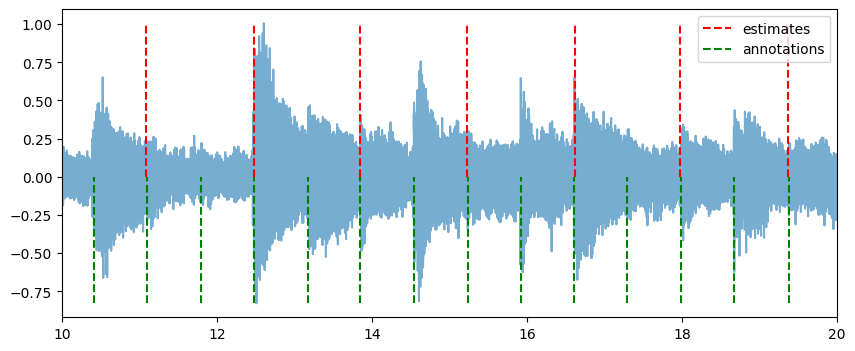

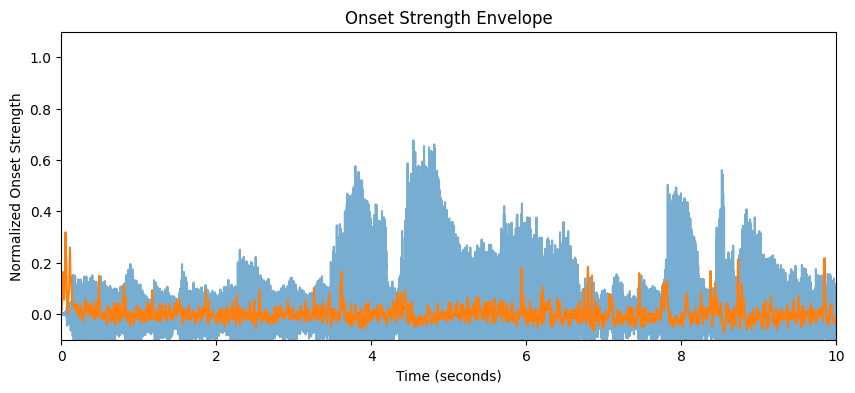

faster_tempo_level: 730.9558417840141, slower_tempo_level 691.4782026179184
faster_tempo weigth: 0.5138767907452236, slower_tempo weight 0.4861232092547763
weight ratio: 0.02775358149044732


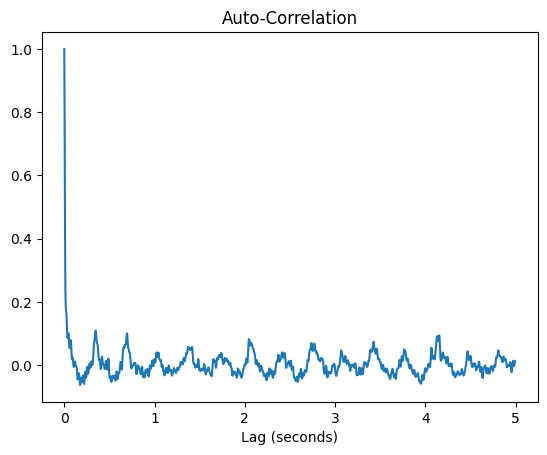

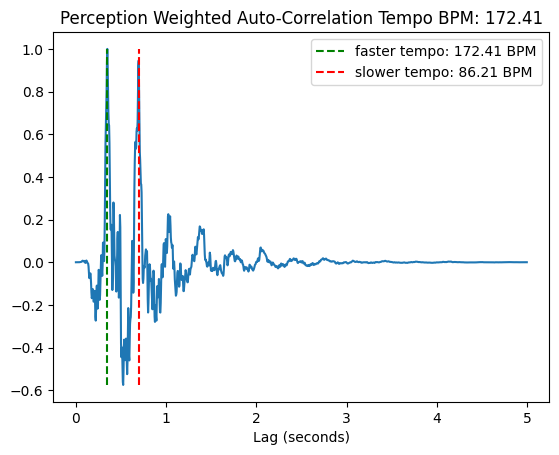

data/BallroomData/Waltz/Media-104604.wav
[ 0.488  0.832  1.172  1.516  1.864  2.208  2.56   2.912  3.26   3.616
  3.964  4.308  4.652  5.     5.356  5.704  6.048  6.4    6.744  7.096
  7.456  7.792  8.128  8.464  8.808  9.156  9.508  9.848 10.184 10.532
 10.884 11.224 11.584 11.944 12.284 12.624 12.972 13.308 13.644 13.988
 14.328 14.672 15.008 15.34  15.684 16.024 16.38  16.728 17.076 17.412
 17.748 18.1   18.46  18.804 19.156 19.492 19.824 20.152 20.5   20.844
 21.192 21.54  21.888 22.232 22.58  22.928 23.276 23.624 23.972 24.312
 24.672 25.02  25.376 25.712 26.048 26.396 26.744 27.092 27.428 27.772
 28.108 28.448 28.796 29.152 29.504 29.856 30.204]
0.6564885496183206


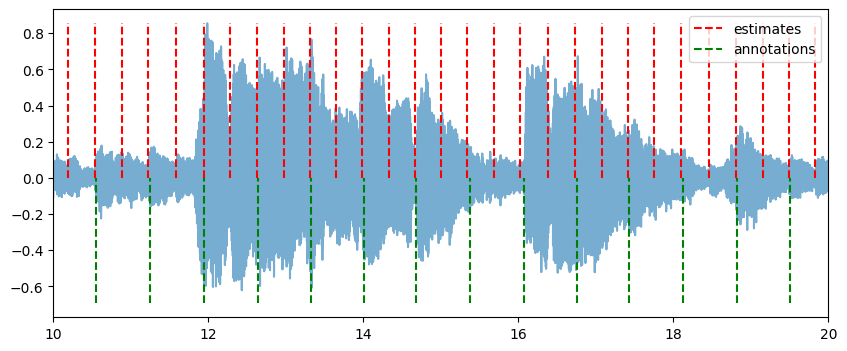

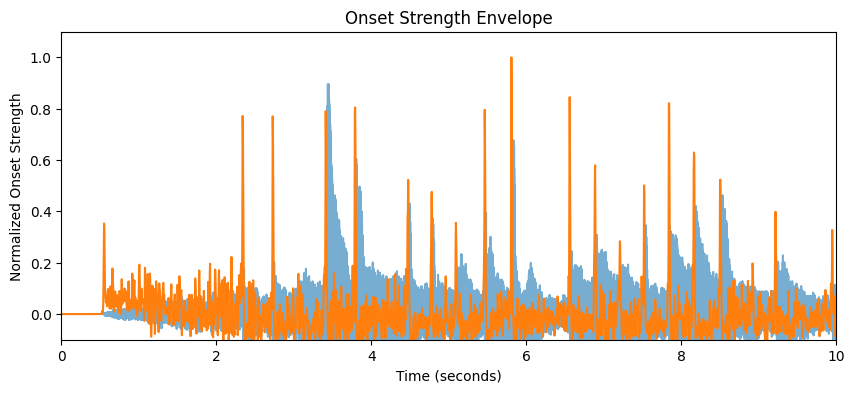

faster_tempo_level: 1522.777011430684, slower_tempo_level 1033.9734557767256
faster_tempo weigth: 0.5955907825036696, slower_tempo weight 0.40440921749633035
weight ratio: 0.19118156500733924


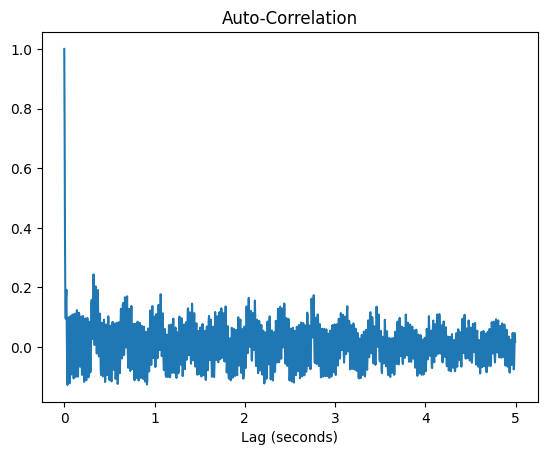

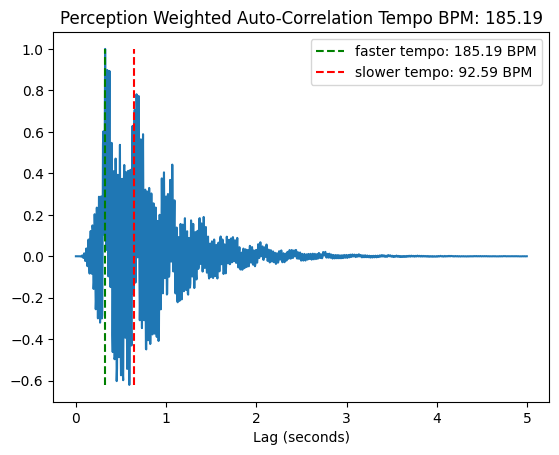

data/BallroomData/Waltz/Albums-Step_By_Step-02.wav
[ 0.492  0.816  1.14   1.464  1.78   2.108  2.424  2.732  3.06   3.388
  3.708  4.024  4.332  4.644  4.96   5.284  5.612  5.936  6.248  6.56
  6.888  7.208  7.524  7.844  8.168  8.5    8.824  9.16   9.48   9.796
 10.12  10.428 10.744 11.072 11.396 11.72  12.048 12.372 12.7   13.02
 13.348 13.664 13.996 14.324 14.644 14.976 15.304 15.628 15.952 16.276
 16.592 16.916 17.244 17.572 17.896 18.216 18.544 18.872 19.192 19.516
 19.84  20.168 20.496 20.84  21.168 21.492 21.816 22.14  22.468 22.792
 23.116 23.44  23.768 24.092 24.416 24.74  25.064 25.392 25.716 26.044
 26.368 26.692 27.02  27.332 27.648 27.972 28.296 28.612 28.936 29.264
 29.596 29.924]
0.3157894736842105


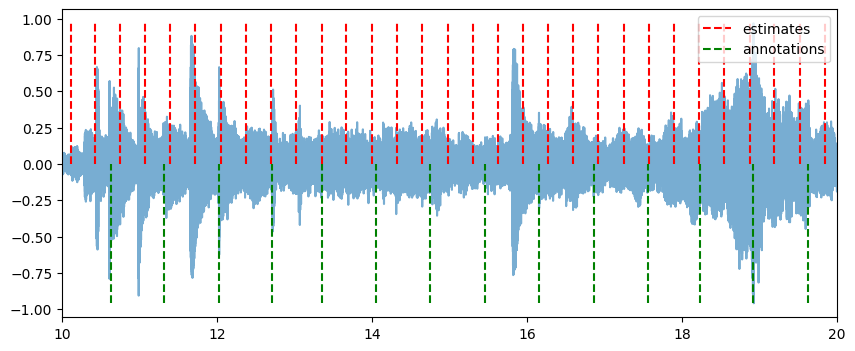

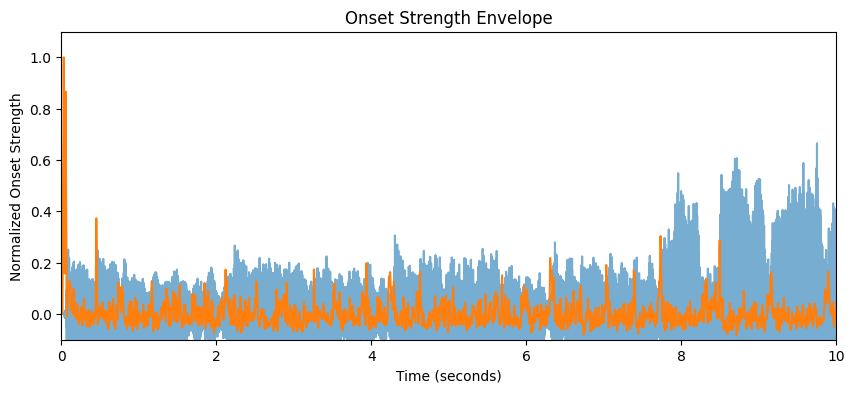

faster_tempo_level: 566.4749727450031, slower_tempo_level 891.3569442911867
faster_tempo weigth: 0.3885735839126513, slower_tempo weight 0.6114264160873488
weight ratio: 0.22285283217469753


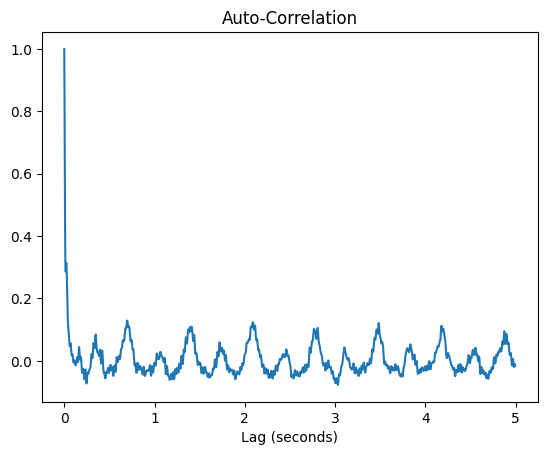

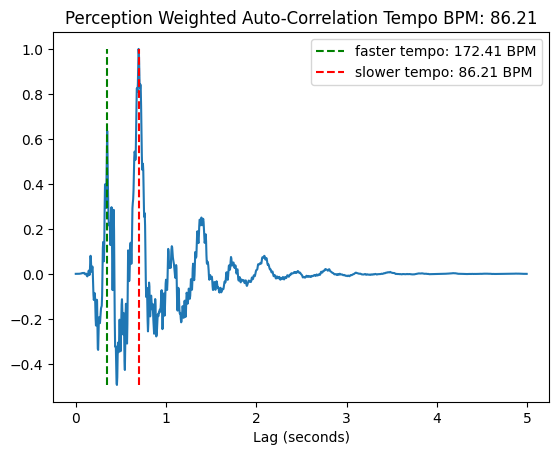

data/BallroomData/Waltz/Media-104402.wav
[ 0.736  1.444  2.12   2.824  3.524  4.228  4.912  5.608  6.308  7.032
  7.732  8.444  9.16   9.856 10.552 11.232 11.924 12.608 13.284 13.976
 14.668 15.376 16.072 16.792 17.496 18.172 18.86  19.52  20.22  20.924
 21.624 22.324 23.012 23.704 24.388 25.076 25.78  26.48  27.168 27.856
 28.54  29.24  29.924]
0.896551724137931


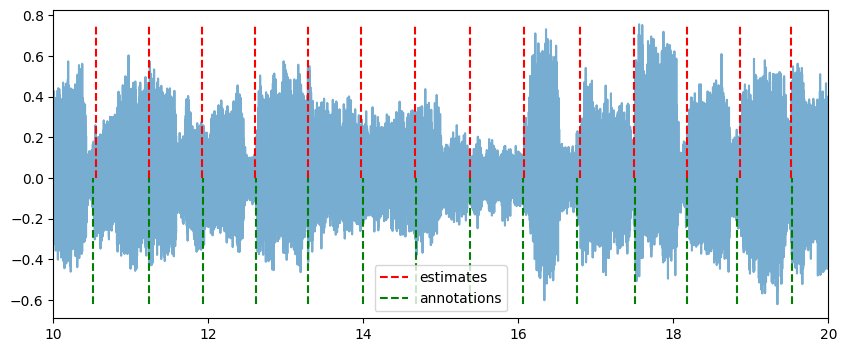

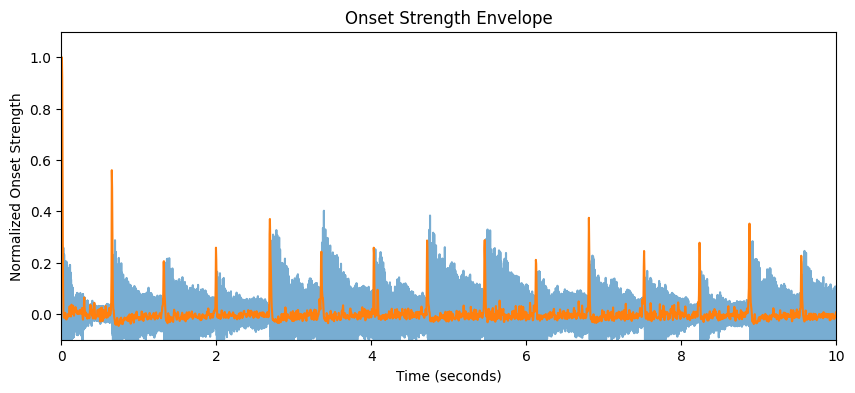

faster_tempo_level: 1346.0474458049027, slower_tempo_level -16.578080704369388
faster_tempo weigth: 1.0124696974142882, slower_tempo weight -0.012469697414288118
weight ratio: 1.0249393948285763


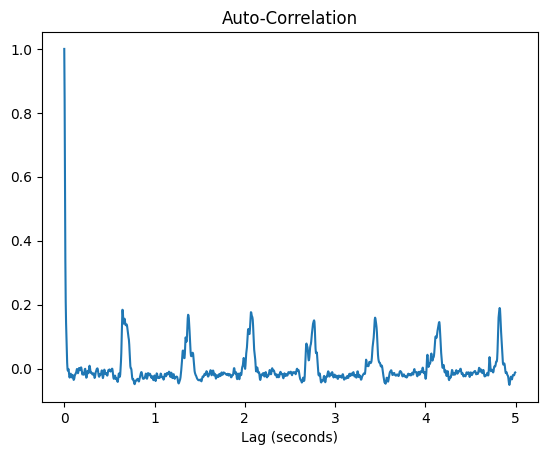

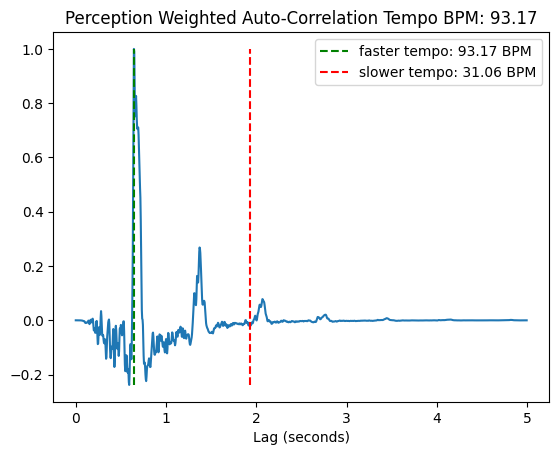

data/BallroomData/Waltz/Media-104204.wav
[ 0.652  1.324  1.996  2.692  3.356  4.032  4.72   5.464  6.124  6.808
  7.52   8.236  8.88   9.548 10.248 10.964 11.632 12.344 13.048 13.704
 14.388 15.016 15.668 16.316 16.968 17.62  18.272 18.916 19.556 20.196
 20.828 21.468 22.116 22.748 23.384 24.06  24.712 25.356 25.992 26.64
 27.26  27.908 28.544 29.188]
0.5747126436781609


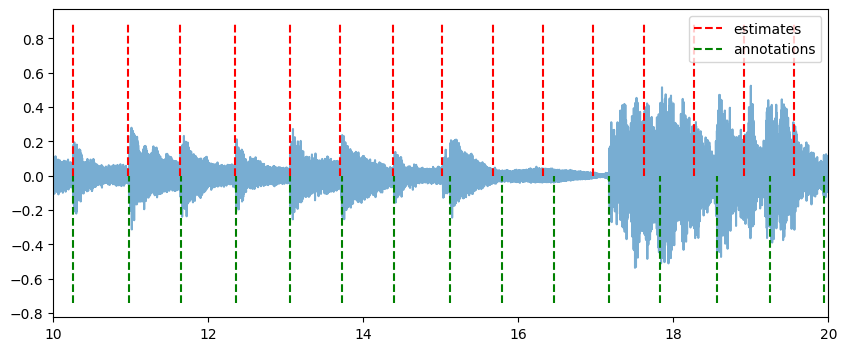

In [17]:
import os

class Song:
    name = None
    audio_file = None
    annotations_file = None
    genre = None
    meter = None
    beats_reference = None # change to beat annotations ?
    beats_estimates = None # ?? not used currently
    evaluation = None

def get_beat_annotations(beats_path):
    beats_file = open(beats_path, 'r')
    beats_lines = beats_file.readlines()
    beats_reference = np.array([])

    for line in beats_lines:
        beat = line[:10]
        beats_reference = np.append(beats_reference, float(beat))
       
    return beats_reference 
 
def read_data(audio_dir ,annotation_dir ,recompute = 0):
    """Creates an array of objects, one for each file, containing path names
    for audio and annotation files, dance style, metre and tempo.
    Each audio file is in a folder defining the dance style
    (e.g. samba, cha cha, waltz). A parallel set of annotation files contain
    two integers for each piece giving the beginning and end of the first bar,
    in milliseconds.
    """
    dump_file = 'data/ballroom_data_dump.npy'
    if not recompute and os.path.exists(dump_file):
        return np.load(dump_file, allow_pickle=True)
    
    songs: Song = []
    for entry in os.scandir(audio_dir):
        if os.path.isdir(entry) == False: continue # ignore hidden files
     
        for file in os.scandir(entry.path):
            song = Song()
            song.audio_file = file.path
            song.annotations_file = annotation_dir + '/' + file.name[:-4] + ".beats"
            song.name = file.name[:-4]
            song.genre = entry.name
            if song.genre[-5:] == 'Waltz':
                song.metre = 3
            else:
                song.metre = 4
            song.beats_reference = get_beat_annotations(song.annotations_file)
            # obj.barTimes = np.divide(np.fromfile(obj.baseName + '.beats', sep = ' '),
            #                      1000)
            # obj.tempo = 60 / (obj.barTimes[1] - obj.barTimes[0]) - could use for testing beat tracker with known bpm
            songs.append(song)
            
    np.save(dump_file, songs)
    return songs

# The whole system should be called via this function
def beatTrack(audio_file, annotations=[], show=False):
    hop_sec=0.004
    resample_rate = 8000

    # load audio
    y, sr = librosa.load(audio_file, sr=resample_rate)
    ose = onset_strength_envelope(y, sr, hop_sec=hop_sec, show=True)
    tempo_estimate = estimate_tempo(ose, sr, hop_sec=hop_sec, show=True)
    beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec, show=False) 
    
    if(show and len(annotations) > 0): 
        # plot estimated vs reference 
        plt.figure(figsize=(10, 4))
        plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
        plt.vlines(beats_estimates, ymin=0, ymax=max(y), color='r', linestyle='--', label='estimates')  # plot beats
        plt.vlines(annotations, ymin=min(y), ymax=0, color='g', linestyle='--', label='annotations')  # plot annotations
        plt.legend()
        plt.xlim([10, 20])
    
    return beats_estimates
    
def test_dataset(songs_data):
    for song in songs_data[:10]:
        beats = beatTrack(song.audio_file, annotations=song.beats_reference, show=True)
        # should this happend seperatly ?
        evaluation_results = evaluation(song.beats_reference, beats)
        print(song.audio_file)
        print(beats)
        print(evaluation_results['f_measure'])
        
# evaluate results
    # take average of all measures
    # visualise etc       

songs_data = read_data('data/BallroomData','data/BallroomAnnotations', recompute = 1)

test_dataset(songs_data)



# run evaluation of results
 # total accuracy - which measure is best ?
 # plot 
 
# evaluate different free variables